In [14]:
# !pip3 install -r requirements.txt
!pip3 install seaborn
!pip3 install matplotlib
!pip3 install pandas
!pip3 install numpy
!pip3 install scikit-learn
!pip3 install opencv-python

!pip3 install transformers datasets
!pip3 install torch torchvision
!pip3 install pillow

In [15]:
import seaborn as sns
import pandas as pd
import numpy as np
import cv2

from matplotlib import pyplot as plt

import torch
from transformers import ViTImageProcessor, ViTForImageClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from torchvision import transforms
from PIL import Image

BASE_DIR = "/home/hmont/Documents/cours/INSA-LYON/5IF/PSAT/Galaxy_Morphology_Classification"

/home/hmont/Documents/cours/INSA-LYON/5IF/PSAT/Galaxy_Morphology_Classification/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Data extraction

file_path_T = f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_attributes.txt"
file_path_label = f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_HyperLeda.txt"
file_path_angle = f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_PGC.txt"

df_T = pd.read_csv(file_path_T, sep='\s+', comment='#', header=None,
                       names=[
                           'PGC_name', 'T', 'T_inf', 'T_sup', 
                           'Bulge_to_Total', 'Bulge_to_Total_inf', 'Bulge_to_Total_sup',
                           'Arm_Strength', 'Arm_Strength_inf', 'Arm_Strength_sup', 
                           'Arm_Curvature', 'Arm_Curvature_inf', 'Arm_Curvature_sup',
                           'Arm_Rotation', 'Arm_Rotation_inf', 'Arm_Rotation_sup', 
                           'Bar_Length', 'Bar_Length_inf', 'Bar_Length_sup',
                           'Inner_Ring', 'Inner_Ring_inf', 'Inner_Ring_sup',
                           'Outer_Ring', 'Outer_Ring_inf', 'Outer_Ring_sup', 
                           'Pseudo_Ring', 'Pseudo_Ring_inf', 'Pseudo_Ring_sup',
                           'Perturbation', 'Perturbation_inf', 'Perturbation_sup',
                           'Visible_Dust', 'Visible_Dust_inf', 'Visible_Dust_sup',
                           'Dust_Dispersion', 'Dust_Dispersion_inf', 'Dust_Dispersion_sup',
                           'Flocculence', 'Flocculence_inf', 'Flocculence_sup',
                           'Hot_Spots', 'Hot_Spots_inf', 'Hot_Spots_sup', 
                           'Inclination', 'Inclination_inf', 'Inclination_sup',
                           'Contamination', 'Contamination_inf', 'Contamination_sup',
                           'Multiplicity', 'Multiplicity_inf', 'Multiplicity_sup'
                       ])

df_label = pd.read_csv(file_path_label, sep='\s+', comment='#', header=None,
                names=['PGC_name', 'PGC_no', 'vrad', 'e_vrad', 'vopt', 'e_vopt', 
                        'v', 'e_v', 'vvir', 'zvir', 'z_err', 'type', 'objname', 'hl_names'])

df_pgc = pd.read_csv(file_path_angle, sep='\s+', comment='#', header=None, 
                     names=['PGC_name', 'T_PGC', 'T_PGC_err', 'type_expanded', 'D25', 
                            'R25', 'PA', 'B_T_mag', 'e_B_T_mag', 'B_V_T', 'e_B_V_T', 
                            'cz', 'z'])

df_filtered = df_label[['PGC_name', 'type']]
df_label_T = pd.merge(df_filtered, df_T[['PGC_name', 'T', 'Inclination']], on='PGC_name', how='left')
data = pd.merge(df_label_T, df_pgc[['PGC_name', 'PA']], on='PGC_name', how='left')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4458 entries, 0 to 4457
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PGC_name     4458 non-null   object 
 1   type         4458 non-null   object 
 2   T            4458 non-null   int64  
 3   Inclination  4458 non-null   float64
 4   PA           4458 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:28: SyntaxWarning: invalid escape sequence '\s'
<>:32: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_14860/1021608000.py:7: SyntaxWarning: invalid escape sequence '\s'
  df_T = pd.read_csv(file_path_T, sep='\s+', comment='#', header=None,
/tmp/ipykernel_14860/1021608000.py:28: SyntaxWarning: invalid escape sequence '\s'
  df_label = pd.read_csv(file_path_label, sep='\s+', comment='#', header=None,
/tmp/ipykernel_14860/1021608000.py:32: SyntaxWarning: invalid escape sequence '\s'
  df_pgc = pd.read_csv(file_path_angle, sep='\s+', comment='#', header=None,


Index : 0 | type : Sab | T : 1 | Inclination : 0.75 | angle : 54
Dimension de l'image : (255, 255, 3)


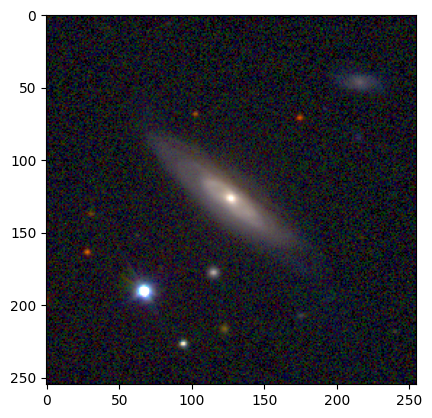

In [9]:
# Data vizualisation
index = 0

image = cv2.imread(f"{BASE_DIR}/data/efigi_png_gri-1.6/png/{data['PGC_name'][index]}.png")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Index : {index} | type : {data['type'][index]} | T : {data['T'][index]} | Inclination : {data['Inclination'][index]} | angle : {data['PA'][index]}")
print(f"Dimension de l'image : {image.shape}")

plt.imshow(image)
plt.show()

Nombre de classes uniques dans T : 18
Nombre de classes uniques dans type : 30


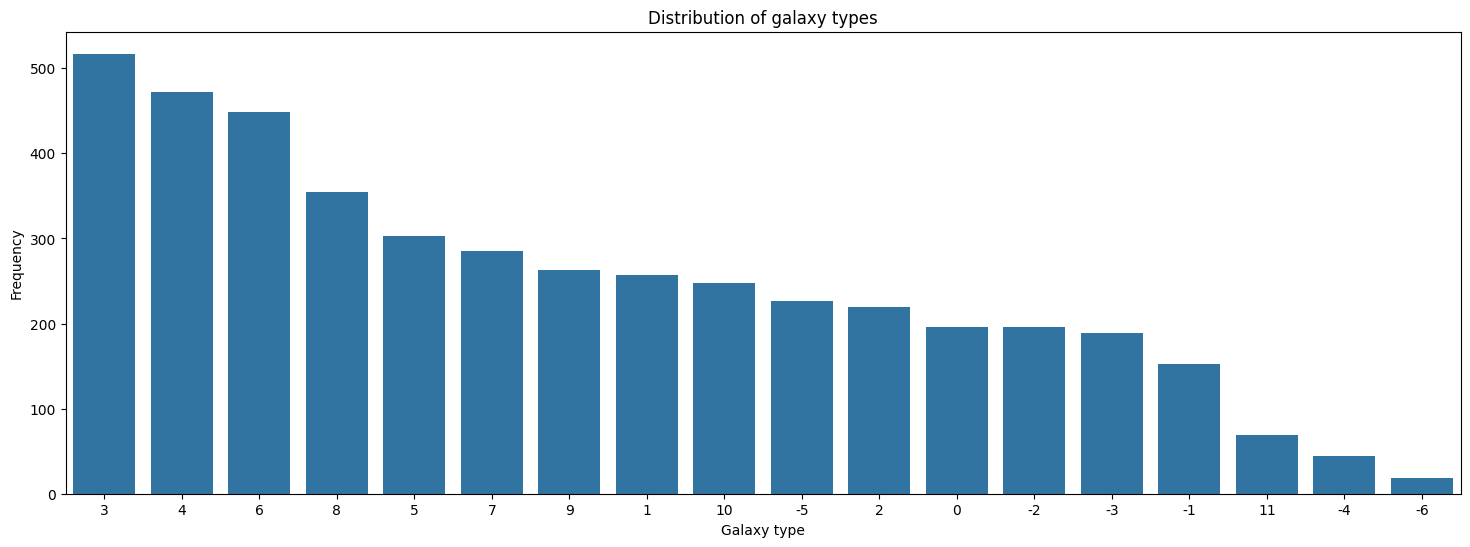

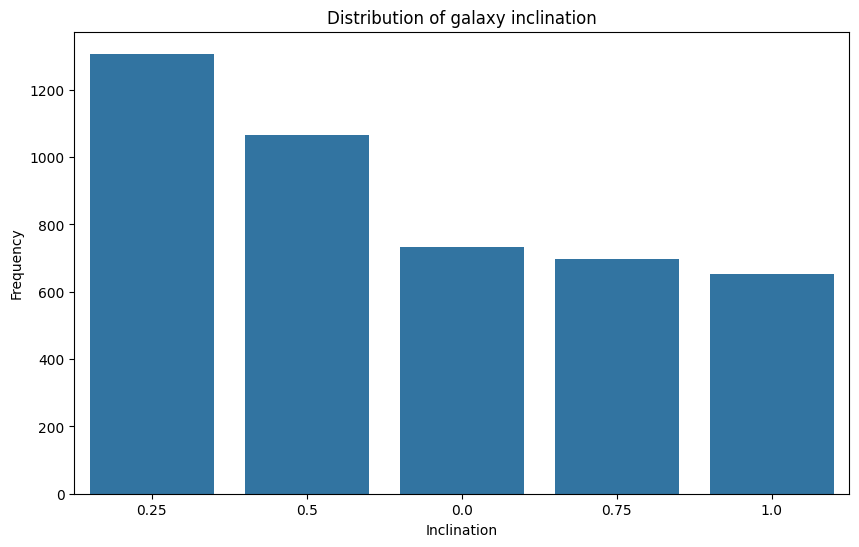

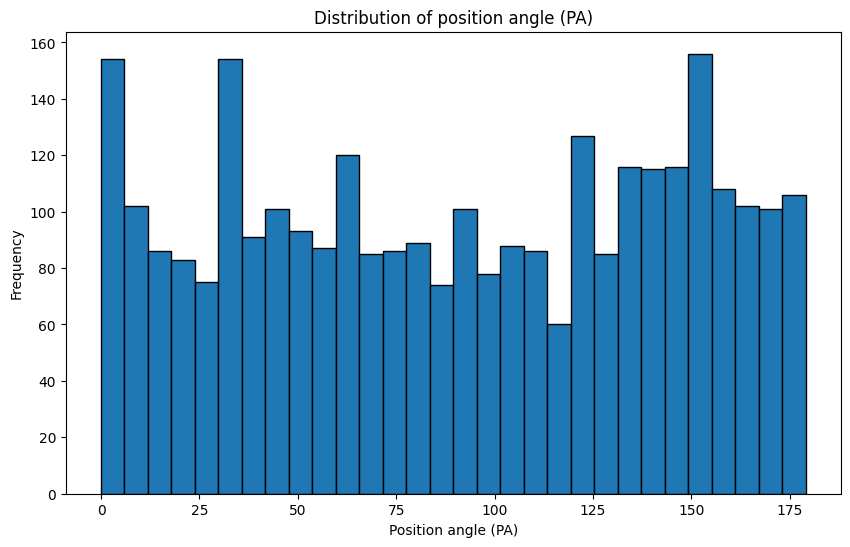

In [10]:
# Data exploration

angle_filtered = data[data['PA'] != -9999]

print(f"Nombre de classes uniques dans T : {data['T'].nunique()}")
print(f"Nombre de classes uniques dans type : {data['type'].nunique()}")

plt.figure(figsize=(18, 6))
sns.countplot(x='T', data=data, order=data['T'].value_counts().index)
# sns.countplot(x='type', data=data, order=data['type'].value_counts().index)
plt.title('Distribution of galaxy types')
plt.xlabel('Galaxy type')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(x='Inclination', data=data, order=data['Inclination'].value_counts().index)
plt.title('Distribution of galaxy inclination')
plt.xlabel('Inclination')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(angle_filtered['PA'], bins=30, edgecolor='black')
plt.title('Distribution of position angle (PA)')
plt.xlabel('Position angle (PA)')
plt.ylabel('Frequency')
plt.show()

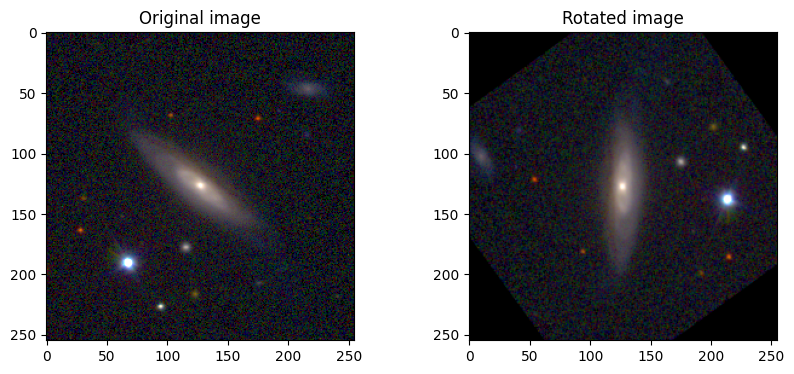

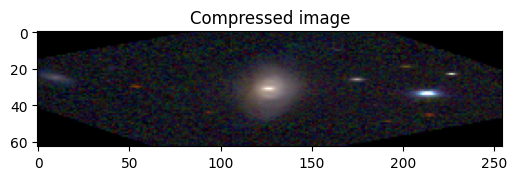

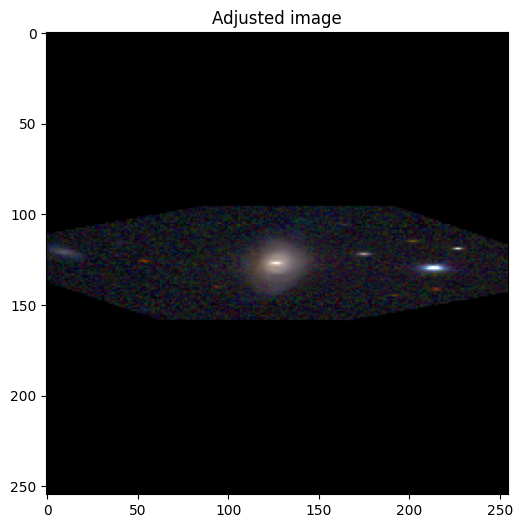

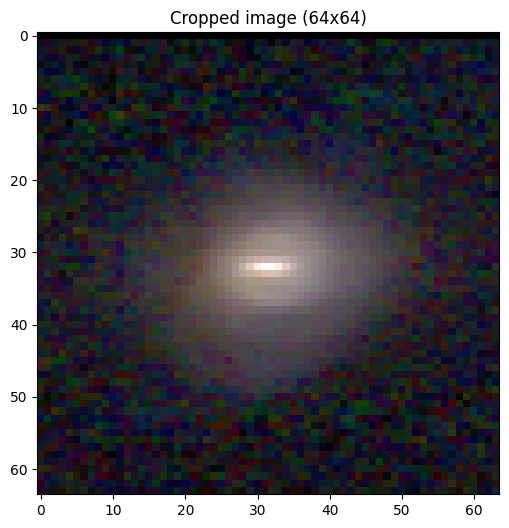

In [11]:
# Data preprocessing

index = 0

image_path = f"{BASE_DIR}/data/efigi_png_gri-1.6/png/{data['PGC_name'][index]}.png"
angle = data['PA'][index]

image = cv2.imread(image_path)
height, width = image.shape[:2]

# Rotation
M = cv2.getRotationMatrix2D((width // 2, height // 2), 180 - angle, 1)
rotated_image = cv2.warpAffine(image, M, (width, height))

# Vertical compression based on inclination
scale_factor = 1 - data['Inclination'][index]
compressed_image = cv2.resize(rotated_image, (width, int(height * scale_factor)))

# Normalization
pad_top = (height - compressed_image.shape[0]) // 2
pad_bottom = height - compressed_image.shape[0] - pad_top
adjusted_image = cv2.copyMakeBorder(compressed_image, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])

# Image cropping
crop_size = 64
center_x, center_y = width // 2, height // 2
start_x = center_x - crop_size // 2
start_y = center_y - crop_size // 2
cropped_image = adjusted_image[start_y:start_y + crop_size, start_x:start_x + crop_size]

# Origin - Rotated
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original image')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(rotated_image, cv2.COLOR_BGR2RGB))
plt.title('Rotated image')
plt.show()

# Compressed
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB))
plt.title('Compressed image')
plt.show()

# Adjusted
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(adjusted_image, cv2.COLOR_BGR2RGB))
plt.title('Adjusted image')
plt.show()

# Cropped
plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title('Cropped image (64x64)')
plt.show()

## Fine tuning general model

In [16]:
# Load and preprocess the dataset
def preprocess_data(data, BASE_DIR):
    """Preprocess data with rotation, compression, normalization, and cropping as in Jupyter Notebook."""
    images, labels = [], []
    
    for i, row in data.iterrows():
        # Load image
        image_path = f"{BASE_DIR}/data/efigi_png_gri-1.6/png/{row['PGC_name']}.png"
        angle, inclination = row['PA'], row['Inclination']
        image = cv2.imread(image_path)
        
        # Rotate
        height, width = image.shape[:2]
        M = cv2.getRotationMatrix2D((width // 2, height // 2), 180 - angle, 1)
        rotated_image = cv2.warpAffine(image, M, (width, height))
        
        # Compress based on inclination
        scale_factor = 1 - inclination
        compressed_image = cv2.resize(rotated_image, (width, int(height * scale_factor)))
        
        # Normalize
        pad_top = (height - compressed_image.shape[0]) // 2
        pad_bottom = height - compressed_image.shape[0] - pad_top
        adjusted_image = cv2.copyMakeBorder(compressed_image, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=[0, 0, 0])
        
        # Crop the central region
        crop_size = 64
        center_x, center_y = width // 2, height // 2
        start_x = center_x - crop_size // 2
        start_y = center_y - crop_size // 2
        cropped_image = adjusted_image[start_y:start_y + crop_size, start_x:start_x + crop_size]
        
        # Convert to PIL Image and add to dataset
        images.append(Image.fromarray(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB)))
        labels.append(row['T'])  # Replace 'T' with the correct label column if needed
    
    return images, labels

# Load and preprocess your data
BASE_DIR = "/home/hmont/Documents/cours/INSA-LYON/5IF/PSAT/Galaxy_Morphology_Classification"
data = pd.read_csv(f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_attributes.txt", sep='\s+', comment='#')
images, labels = preprocess_data(data, BASE_DIR)

# Define the Hugging Face dataset
dataset = Dataset.from_dict({'image': images, 'label': labels})

# Define transformation for model input
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
def transform(example):
    example['pixel_values'] = processor(images=example['image'], return_tensors="pt").pixel_values[0]
    return example

# Apply transformation to the dataset
dataset = dataset.map(transform)
dataset = dataset.train_test_split(test_size=0.2)

# Prepare model for fine-tuning
num_labels = len(set(labels))
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=num_labels)

# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True
)

# Define the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset['train'],
    eval_dataset=dataset['test'],
)

# Train the model
trainer.train()

<>:41: SyntaxWarning: invalid escape sequence '\s'
<>:41: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_14860/641446468.py:41: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_attributes.txt", sep='\s+', comment='#')
/tmp/ipykernel_14860/641446468.py:41: SyntaxWarning: invalid escape sequence '\s'
  data = pd.read_csv(f"{BASE_DIR}/data/efigi_tables-1.6.2/EFIGI_attributes.txt", sep='\s+', comment='#')


KeyError: 'PGC_name'